# Bray–Curtis dissimilarity between regions defined by important historical boundaries

Compare historical regions in terms of their building composition using Bray–Curtis dissimilarity statistic.

In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
import os

import preprocess_data

Retrieve building dataset and levels of clusters

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

List layers of influential boundaries across Central European history

In [3]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [4]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)
boundary_list.remove("1812_political") #to be fixed
boundary_list.remove("1900_germans") #to be fixed
boundary_list.remove("1300_ostsiedlung") #to be fixed

Define area of interest (Central Europe sans Hungary)

<Axes: >

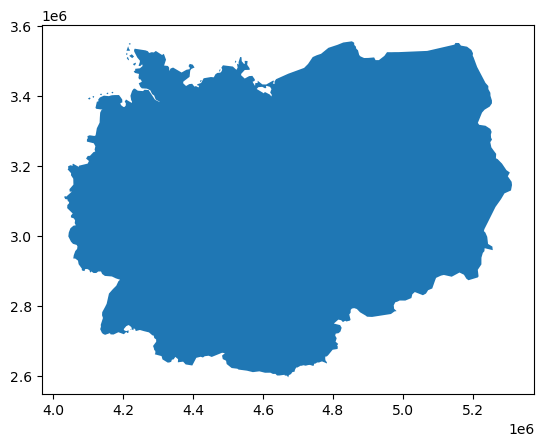

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

**Example**: Consider `1994_political` map

In [6]:
layer_of_interest = boundary_list[-1]

Retrieve building counts per region and normalize

In [7]:
building_counts = preprocess_data.get_building_counts_per_region(buildings, gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=layer_of_interest))

In [8]:
normalized_building_counts = preprocess_data.normalize_building_counts(building_counts)

In [9]:
normalized_building_counts

level_4,1,2,3,4,5,6,7,8
NAME,,,,,,,,
Austria,0.030459,0.022281,0.051087,0.342864,0.273926,0.025865,0.182510,0.071009
Czechia,0.059720,0.025199,0.054868,0.267304,0.261415,0.019600,0.164712,0.147181
Germany,0.037207,0.035228,0.037582,0.061221,0.132295,0.022030,0.562386,0.112051
Poland,0.050752,0.018854,0.270822,0.333431,0.163006,0.005040,0.131477,0.026617
Slovakia,0.040013,0.018405,0.112308,0.068185,0.212175,0.007539,0.514653,0.026721


Compute pairwise Bray–Curtis dissimilarity matrix

In [10]:
def compute_bc_matrix(count_table):
    bray_curtis_dist = distance.pdist(count_table, metric='braycurtis')
    bray_curtis_matrix = distance.squareform(bray_curtis_dist)
    bray_curtis_df = pd.DataFrame(bray_curtis_matrix, index=count_table.T.columns, columns=count_table.T.columns)
    return bray_curtis_df

In [11]:
bray_curtis_matrix = compute_bc_matrix(normalized_building_counts)
bray_curtis_matrix

NAME,Austria,Czechia,Germany,Poland,Slovakia
NAME,,,,,
Austria,0.000000,0.112133,0.440613,0.240029,0.402918
Czechia,0.112133,0.000000,0.410132,0.282081,0.407382
Germany,0.440613,0.410132,0.000000,0.549706,0.164376
Poland,0.240029,0.282081,0.549706,0.000000,0.434948
Slovakia,0.402918,0.407382,0.164376,0.434948,0.000000


Plot as a heatmap

<Axes: xlabel='NAME', ylabel='NAME'>

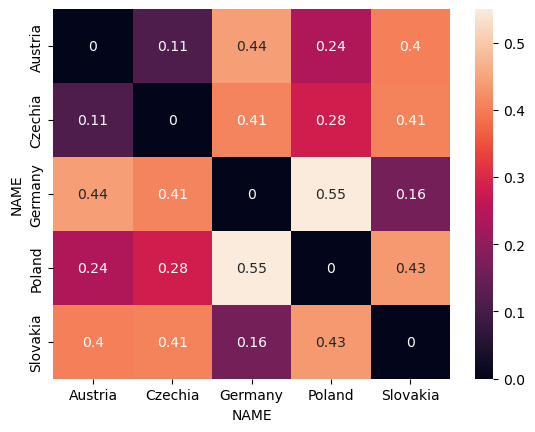

In [12]:
sns.heatmap(bray_curtis_matrix, annot=True)

Compute Bray–Curtis matrix for each cluster level

In [15]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

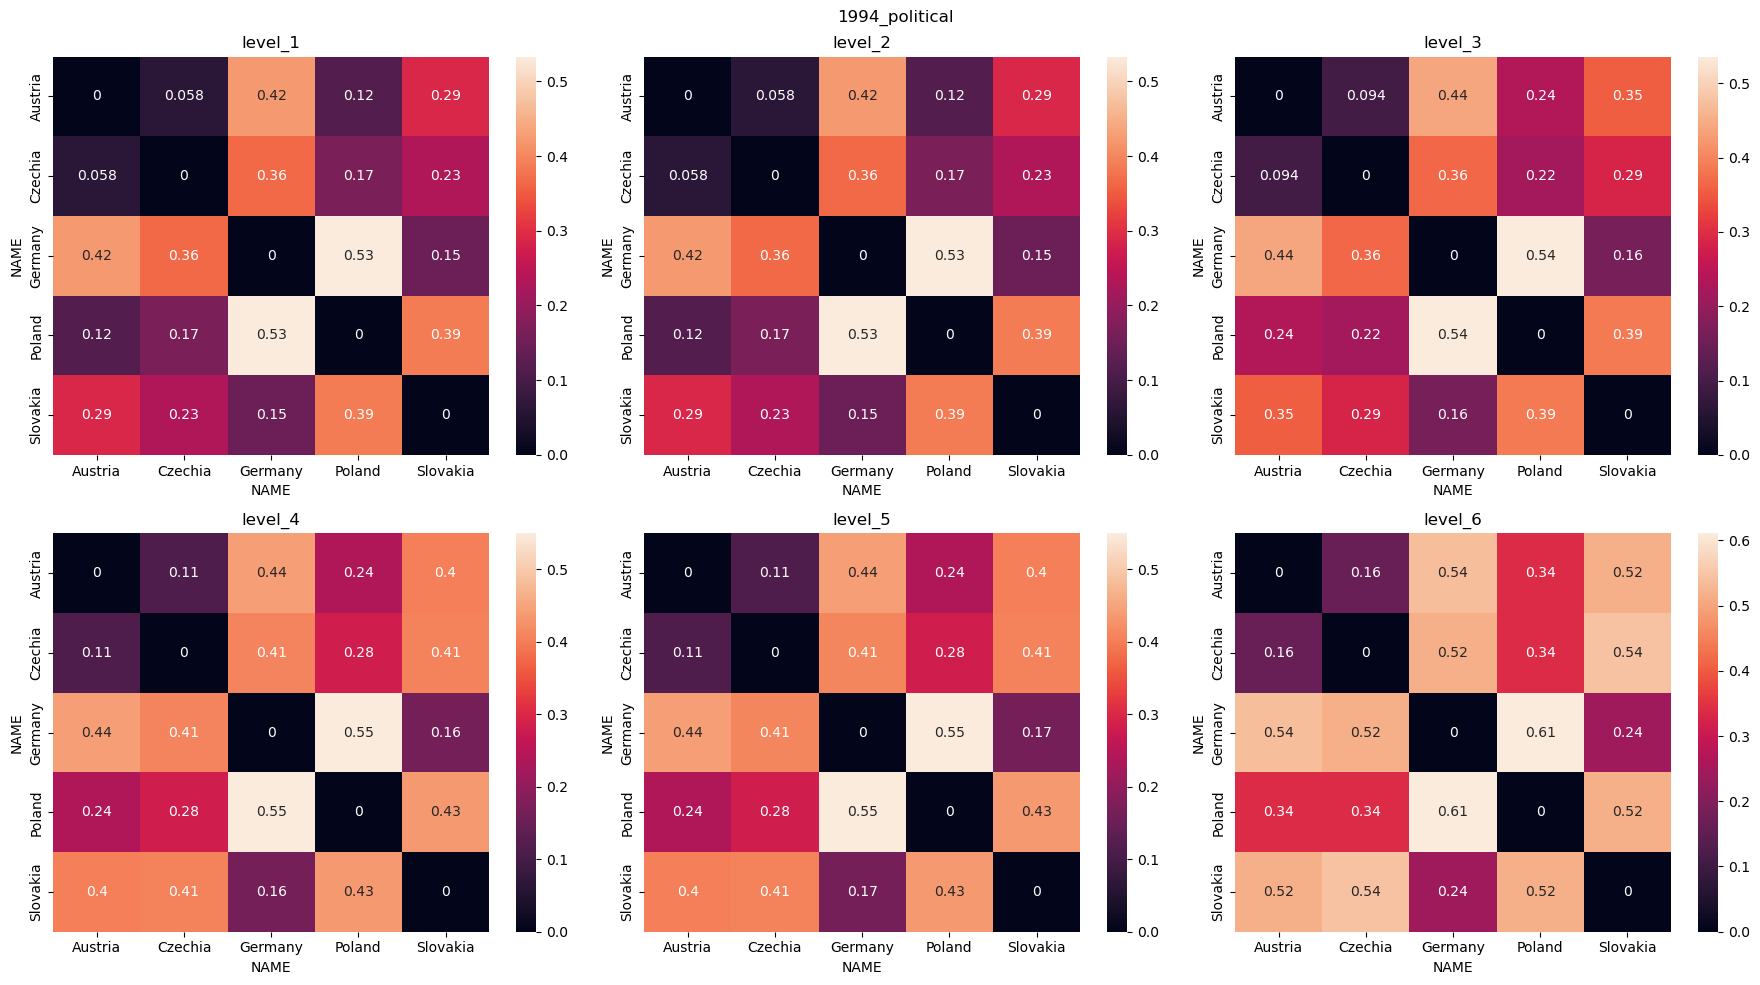

In [16]:
generate_bc_heatmaps_for_boundary(levels, layer_of_interest)

## Run to generate Bray–Curtis matrices for each level and historical layer, save to parquet

In [13]:
from tqdm import tqdm

def generate_bc_matrices(list_of_boundaries, level_list):
    bc_matrices_path = "/data/uscuni-ulce/boundaries_of_change/bc_matrices/"
    if not os.path.exists(bc_matrices_path):
        os.mkdir(bc_matrices_path)
    for bnd in tqdm(list_of_boundaries, desc=f"Processing boundaries..."):
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in tqdm(level_list, desc=f"Generating matrices for {bnd}"):
            building_counts = preprocess_data.get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = preprocess_data.normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
            output_path = os.path.join(bc_matrices_path, f'bc_{bnd}_{level}.pq')
            bray_curtis_matrix.to_parquet(output_path)

In [14]:
generate_bc_matrices(boundary_list, levels)

Processing boundaries...: 100%|████████████████████████████████████████████████████████| 15/15 [48:26<00:00, 193.78s/it]
